In [16]:
import matplotlib.pyplot as plt
import fastf1.plotting
import fastf1
import pandas as pd

fastf1.plotting.setup_mpl(misc_mpl_mods = False)

In [3]:
session = fastf1.get_session(2021, 'Spanish Grand Prix', 'Q')
session.load()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\abdul\AppData\Local\Temp\fastf1.
	Size: 327.01 MB
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.1.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Lo

In [41]:
lec_lap = session.laps.pick_driver('VER').pick_fastest()
ham_lap = session.laps.pick_driver('HAM').pick_fastest()

In [42]:
lec_tel = lec_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

In [43]:
circuit_info = session.get_circuit_info()
corners = circuit_info.corners
corners = corners[['Distance', 'Number']]

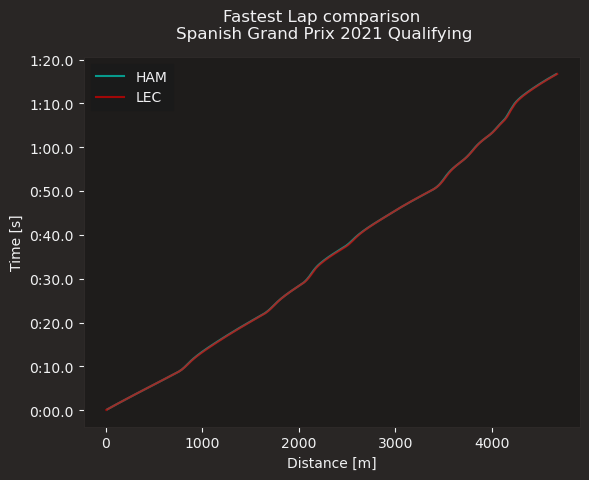

In [45]:
fer_color = fastf1.plotting.team_color('FER')
mer_color = fastf1.plotting.team_color('MER')


fig, ax = plt.subplots()
ax.plot(ham_tel['Distance'], ham_tel['Time'], color=mer_color, label='HAM', alpha=0.7)
ax.plot(lec_tel['Distance'], lec_tel['Time'], color=fer_color, label='LEC', alpha = 0.7)

ax.set_xlabel('Distance [m]')
ax.set_ylabel('Time [s]')
ax.legend()
plt.suptitle(f'Fastest Lap comparison \n'
             f"{session.event.EventName} {session.event.year} Qualifying")
plt.show()